In [1]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from alg import * 

In [23]:
class Binary_Classifier():

    def __init__(self, train_data, reduction=10):
        # 对数据进行PCA降维
        self.train_data = train_data.copy()
        pca_res = Reduction.pca(train_data, reduction)
        self.data, self.eigen_vec, self.mean = pca_res
        dif = train_data - self.mean
        weights = self.eigen_vec.T.dot(dif)
        reconst = np.zeros(train_data.shape)
        for i, weight in enumerate(weights.T):
            reconst[:, i] = np.sum(weight * self.eigen_vec, axis=1)
        dists = np.linalg.norm(dif-reconst, axis=0)
        self.dists = dists
        self.max_dist = np.max(dists)
        # 记录训练数据的方差
        train_var = np.var(train_data, axis=0, keepdims=True)
        self.min_var = np.min(train_var)
        
    def tell(self, test_data, threshold=1., no_thr=0.4):
        if test_data.ndim == 1:
            test_data = np.reshape(test_data, (test_data.size, 1))
        # 对测试图像利用训练数据重构
        dif = test_data - self.mean
        weights = self.eigen_vec.T.dot(dif)
        reconst = np.zeros(test_data.shape)
        for i, weight in enumerate(weights.T):
            reconst[:, i] = np.sum(weight * self.eigen_vec, axis=1)
        dists = np.linalg.norm(dif - reconst, axis=0)
        yes_idx = np.where(dists < threshold * self.max_dist)[0]
        res = np.zeros((test_data.shape[1], ))
        res[yes_idx] = 1
        self.test_dists = dists
        self.reconst = reconst

        # # 对于平均或随机得矩阵，不是人脸
        self.check_uniform = np.var(test_data, axis=0, keepdims=True)
        no_idx = np.where(self.check_uniform < self.min_var * no_thr)[0]
        res[no_idx] = 0
        return res

In [3]:
def detectfaces(image, reduction=10, stride=None, threshold=1.5, no_thr=0.4, scale=10, start_scale=1, end_scale=None):
    image = image.copy()
    bc = Binary_Classifier(dataset, reduction)
    # 用一个框，遍历图像，框从图像的1/10开始，渐渐增大
    img = np.array(image).copy()
    if img.ndim == 3:
        img = np.mean(img, axis=2)
    if stride is None:
        stride = max(img.shape) // 20 + 1
    res = []
    if end_scale is None:
        end_scale = scale
    # init_size = (img.shape[0], int(raw_size[1] * (img.shape[0]/raw_size[0])))
    if img.shape[0] < img.shape[1]:
        init_size = (img.shape[0], int(img.shape[0] * (raw_size[1]/raw_size[0])))
    else:
        init_size = (int(img.shape[1] * (raw_size[0]/raw_size[1])), img.shape[1])
    # init_size = (min(img.shape), min(img.shape)) # 图的窄边
    print(init_size)
    proportions = np.array(list(range(1, scale))) / scale # 比例 0.1, 0.05, ... 1.0
    # for proportion in proportions[int(scale*0.6):]:
    for proportion in proportions[start_scale: end_scale]:
        # 图框的大小
        size = np.array([int(init_size[0] * proportion), int(init_size[1] * proportion)], np.int32)
        # 以这个大小的框遍历图像
        lt = np.array([0, 0]) # left_top
        sub_feas = []   
        sub_pos = []
        while lt[0] + size[0] <= img.shape[0]:
            lt[1] = 0
            while lt[1] + size[1] <= img.shape[1]:
                sub_img = img[lt[0]: lt[0]+size[0], lt[1]: lt[1]+size[1]]
                # 把子图 缩放到人脸的尺寸
                sub_fea = cv2.resize(sub_img, raw_size[::-1]).flatten()
                sub_feas.append(sub_fea)
                sub_pos.append([lt.copy(), lt+size])
                lt[1] += stride
            lt[0] += stride
        sub_feas = np.array(sub_feas, np.uint8).T
        res = bc.tell(sub_feas, threshold, no_thr)
        idxs = np.where(res == 1)[0]
        starts = [sub_pos[idx][0] for idx in idxs]
        # print(idxs.size)
        if idxs is not None:
            for idx in idxs :
                start = (sub_pos[idx][0][1], sub_pos[idx][0][0])
                end = (sub_pos[idx][1][1], sub_pos[idx][1][0])
                # print(start, end)
                cv2.rectangle(image, start, end, color=(255, 0, 0), thickness=2)
    return image

In [48]:
def show_one_res(sub, threshold=1.5, nothr=0.5):
    bc = out_bc
    if sub.ndim == 3:
        sub = cv2.resize(sub[:, :, 0], raw_size[::-1])
    elif sub.ndim == 2:
        sub = cv2.resize(sub, raw_size[::-1])
    else:
        sub = np.reshape(sub, raw_size)
    fig, ax = plt.subplots(1, 3, figsize=(7, 3))
    ax[0].imshow(sub)
    sub = np.reshape(sub.flatten(), (sub.size, 1))
    res = bc.tell(sub)
    ax[1].imshow(np.reshape(bc.reconst[:, 0:1], raw_size))
    ax[2].imshow(np.reshape((sub-bc.mean), raw_size))
    ax[0].set_title("origin")
    ax[1].set_title("reconstruct face")
    ax[2].set_title("origin minus meanface")
    print("1：face, 0 non-face：", bc.tell(sub, threshold, nothr))
    print("方差：", bc.check_uniform)
    print("距离：", bc.test_dists)
#     fig.show()

In [17]:
dataset, labels = read_all()
# dataset = dataset.astype(np.int64)
# dataset += np.random.randint(0, 5, (dataset.shape))
# dataset = np.clip(dataset, 0, 255)
out_bc = Binary_Classifier(dataset, reduction=20)
path = "./project1-data-Detection/"
files = os.listdir(path)
imgs = [np.array(Image.open(path+file)) for file in files]
raw_size = (231, 195)

1：face, 0 non-face： [1.]
方差： [[6838.07505155]]
距离： [6538.39750424]


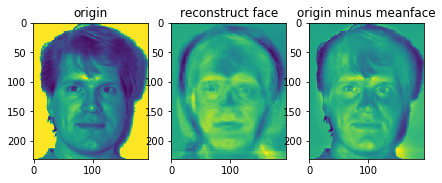

In [49]:
show_one_res(dataset[:, 0])

1：face, 0 non-face： [0.]
方差： [[1148.95889672]]
距离： [11694.52421553]


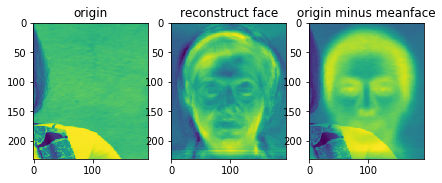

In [50]:
show_one_res(imgs[0][200:560,500:700, :])

1：face, 0 non-face： [0.]
方差： [[3816.04953376]]
距离： [12270.26711215]


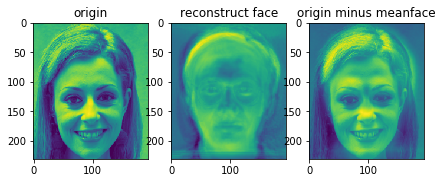

In [51]:
show_one_res(imgs[0][25:425,180:540, :])

1：face, 0 non-face： [0.]
方差： [[3303.30876713]]
距离： [14399.91689566]


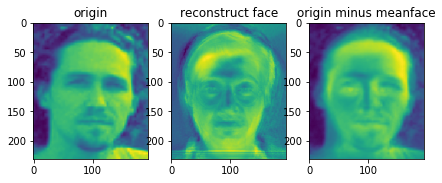

In [52]:
show_one_res(imgs[2][80:140, 235:285])

1：face, 0 non-face： [1.]
方差： [[2896.14262755]]
距离： [8311.94920291]


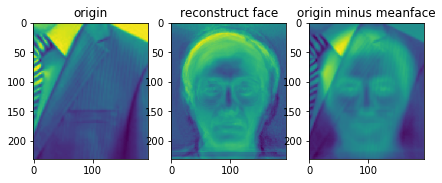

In [53]:
show_one_res(imgs[1][95:179, 305:376 :], 1.15, 0.2)

1：face, 0 non-face： [1.]
方差： [[2878.76408132]]
距离： [11708.18504538]


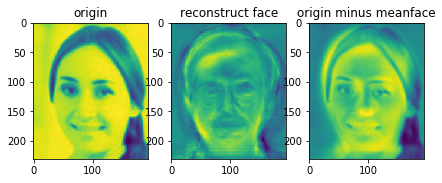

In [54]:
show_one_res(imgs[1][20:100, 55: 125, :], 1.5)

1：face, 0 non-face： [0.]
方差： [[5417.96136307]]
距离： [17533.70921438]


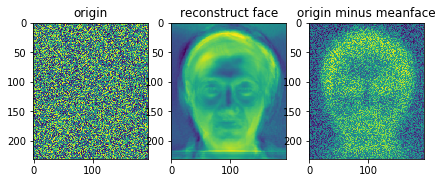

In [55]:
show_one_res(np.random.randint(0, 255, dataset[:, 0].shape))

1：face, 0 non-face： [0.]
方差： [[0.]]
距离： [7905.0984327]


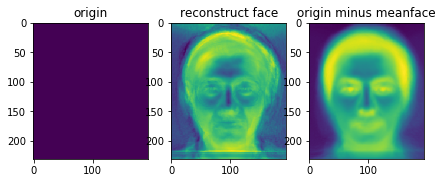

In [56]:
show_one_res(np.ones(dataset[:, 0].shape)*100)

(793, 670)


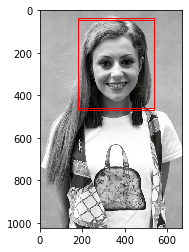

In [59]:
res = detectfaces(imgs[0], 20, 10, 1.4, scale=15, start_scale=7, end_scale=12)
fig, ax = plt.subplots(1, 1)
ax.imshow(res)

(283, 238)


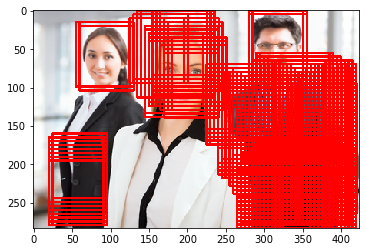

In [62]:
res2 = detectfaces(imgs[1], 10, 5, 1.2, 0.9, scale=10, start_scale=2, end_scale=4)
plt.imshow(res2)

(561, 473)


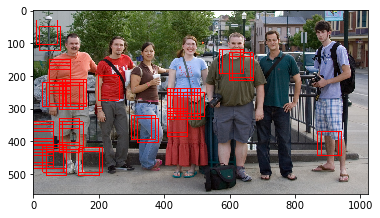

In [63]:
res3 = detectfaces(imgs[2], 5, 10, 0.8, 0.6, scale=15, start_scale=1, end_scale=2)
plt.imshow(res3)
plt.show()